In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
import glob
# import pickle
import random
import re
import nibabel as nib

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# from tensorflow.keras.callbacks import CSVLogger

from keras.models import load_model
# from keras.models import Model
# from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
# from keras.optimizers import Adam
# from keras.metrics import MeanIoU
# import keras.backend as K
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# import keras

2024-01-18 16:23:26.795323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 16:23:26.795371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 16:23:26.796709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 16:23:26.805253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 16:23:27.982454: W tensorflow/compiler/tf2

In [4]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
# Set GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    # Restrict TensorFlow to only allocate memory on the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

[]


2024-01-18 16:23:29.408734: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-18 16:23:29.408780: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: whale
2024-01-18 16:23:29.408787: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: whale
2024-01-18 16:23:29.408973: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.146.2
2024-01-18 16:23:29.408996: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-01-18 16:23:29.409003: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.129.3 does not match DSO version 535.146.2 -- cannot find working devices in this configuration


In [4]:
model = load_model('brats_3d.hdf5', compile=False)

In [5]:
def load_and_combine(mydata_path, split_type, i):
    image_t1=nib.load(os.path.join(mydata_path, f'{split_type}_{i}', f'{split_type}_{i}_t1.nii.gz')).get_fdata()
    image_t1=scaler.fit_transform(image_t1.reshape(-1, image_t1.shape[-1])).reshape(image_t1.shape)

    image_t2=nib.load(os.path.join(mydata_path, f'{split_type}_{i}', f'{split_type}_{i}_t2.nii.gz')).get_fdata()
    image_t2=scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)

    image_t1ce=nib.load(os.path.join(mydata_path, f'{split_type}_{i}', f'{split_type}_{i}_t1ce.nii.gz')).get_fdata()
    image_t1ce=scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)

    image_flair=nib.load(os.path.join(mydata_path, f'{split_type}_{i}', f'{split_type}_{i}_flair.nii.gz')).get_fdata()
    image_flair=scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)

    mask=nib.load(os.path.join(mydata_path, f'{split_type}_{i}', f'{split_type}_{i}_seg.nii.gz')).get_fdata()

    # mask=mask.astype(np.uint8)
    mask[mask==4] = 3
    # mask= to_categorical(mask, num_classes=4)
    combined_x = np.stack([image_t1, image_t2, image_t1ce, image_flair], axis=3)

    combined_x=combined_x[56:184, 56:184, 13:141]
    mask = mask[56:184, 56:184, 13:141]
    
    return combined_x, mask

In [6]:
split_type = 'test' # 'test', 'val'

mydata_path = f'/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/gt_data/{split_type}/data/segmentation' 
mydata_path_cropped = f'/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/gt_data_cropped/{split_type}/data/segmentation' 

img_names = os.listdir(mydata_path)

destination_directory = f'/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/pred_data/{split_type}/data/segmentation/'
os.makedirs(destination_directory, exist_ok=True)


for i in range(len(img_names)):
    
    img, mask = load_and_combine(mydata_path, split_type, i+1)
    img_input = np.expand_dims(img, axis=0)

    prediction = model.predict(img_input)
    
    # mask_argmax=np.argmax(mask, axis=3)
    prediction_argmax=np.argmax(prediction, axis=4)[0,:,:,:]

    # Convert the data type to a more compatible format (e.g., int16)
    mask = mask.astype(np.int16)
    prediction_argmax = prediction_argmax.astype(np.int16)
    
    
    # Create a directory path for the current file
    cropped_img_input = os.path.join(mydata_path_cropped, f'{split_type}_{i+1}')
    prediction_dir = os.path.join(destination_directory, f'{split_type}_{i+1}')
    
    # Ensure the directory exists
    os.makedirs(cropped_img_input, exist_ok=True)
    os.makedirs(prediction_dir, exist_ok=True)
    
    # Create a NIfTI image
    affine = np.eye(4)
    nifti_image_cropped = nib.Nifti1Image(mask, affine)
    nifti_image_pred = nib.Nifti1Image(prediction_argmax, affine)
    
    # Save the NIfTI image
    nifti_file_path_croppd = os.path.join(cropped_img_input, f'{split_type}_{i+1}_seg.nii.gz')
    nifti_file_path_pred = os.path.join(prediction_dir, f'{split_type}_{i+1}_seg.nii.gz')
    
    nib.save(nifti_image_cropped, nifti_file_path_croppd)
    nib.save(nifti_image_pred, nifti_file_path_pred)

2024-01-18 03:05:39.945615: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-18 03:05:40.254718: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 03:05:40.908251: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 03:05:41.619335: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 601.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-18 03:05:41.624473: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 601.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performa

ResourceExhaustedError: Graph execution error:

Detected at node model_1/concatenate_7/concat defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_166853/3093098990.py", line 17, in <module>

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 2655, in predict

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/layers/merging/base_merge.py", line 196, in call

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/layers/merging/concatenate.py", line 134, in _merge_function

  File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/backend.py", line 3580, in concatenate

OOM when allocating tensor with shape[1,32,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/concatenate_7/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_1183]

In [201]:
1

1

In [9]:
# split_type = 'test'

# mydata_path = '/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/BraTS2020_TrainingData/input_data_128/'
# img_names = os.listdir(mydata_path + '/' + split_type + '/images')
# img_ids = sorted(list(map(lambda x: re.split('_|\.', x)[1], img_names)))
# len(img_ids), split_type

# destination_directory = '/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/predictions/split_type/data/segmentation/'
# os.makedirs(destination_directory, exist_ok=True)


# for i, id in enumerate(img_ids):
#     img = np.load(mydata_path + split_type + "/images/image_" + id + ".npy")
#     mask = np.load(mydata_path + split_type + "/masks/mask_" + id + ".npy")

#     mask_argmax=np.argmax(mask, axis=3)
#     img_input = np.expand_dims(img, axis=0)
#     prediction = model.predict(img_input)
#     prediction_argmax=np.argmax(prediction, axis=4)[0,:,:,:]
    
#     # Convert the data type to a more compatible format (e.g., int16)
#     prediction_argmax = prediction_argmax.astype(np.int16)
    
#     # Create a directory path for the current prediction file
#     prediction_dir = os.path.join(destination_directory, f'{split_type}_{i+1}')
    
#     # Ensure the directory exists
#     os.makedirs(prediction_dir, exist_ok=True)
    
#     # Create a NIfTI image from the prediction
#     affine = np.eye(4)
    
#     # Save the NIfTI image
#     nifti_file_path = os.path.join(prediction_dir, f'{split_type}_{i}_seg.nii.gz')
#     nib.save(nifti_image, nifti_file_path)

(139,
 ['test_31',
  'test_11',
  'test_111',
  'test_35',
  'test_84',
  'test_124',
  'test_22',
  'test_100',
  'test_90',
  'test_50',
  'test_110',
  'test_36',
  'test_87',
  'test_103',
  'test_28',
  'test_24',
  'test_12',
  'test_80',
  'test_83',
  'test_66',
  'test_101',
  'test_6',
  'test_48',
  'test_16',
  'test_46',
  'test_18',
  'test_82',
  'test_68',
  'test_51',
  'test_52',
  'test_125',
  'test_54',
  'test_129',
  'test_133',
  'test_75',
  'test_138',
  'test_38',
  'test_89',
  'test_130',
  'test_114',
  'test_91',
  'test_3',
  'test_108',
  'test_44',
  'test_99',
  'test_49',
  'test_19',
  'test_132',
  'test_45',
  'test_27',
  'test_64',
  'test_76',
  'test_106',
  'test_34',
  'test_135',
  'test_126',
  'test_8',
  'test_71',
  'test_42',
  'test_57',
  'test_113',
  'test_59',
  'test_105',
  'test_53',
  'test_26',
  'test_17',
  'test_116',
  'test_119',
  'test_137',
  'test_13',
  'test_85',
  'test_136',
  'test_41',
  'test_20',
  'test_9',


In [7]:
np.unique(ground_truth_data)

NameError: name 'ground_truth_data' is not defined

92


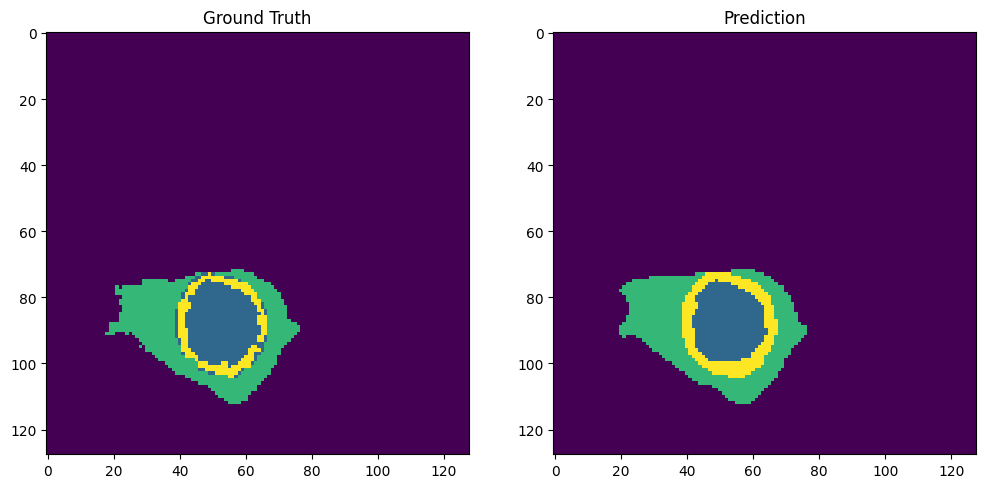

In [124]:
i = 120
# split_type = 'test'

# Paths to your NIfTI files
ground_truth_path_cropped = f'/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/gt_data_cropped/{split_type}/data/segmentation/{split_type}_{i}/{split_type}_{i}_seg.nii.gz'
# ground_truth_path = f'/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/gt_data/test/data/segmentation/{split_type}_{i}/{split_type}_{i}_seg.nii.gz'
predicted_path = f'/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/pred_data/{split_type}/data/segmentation/{split_type}_{i}/{split_type}_{i}_seg.nii.gz'

# Load the NIfTI files
ground_truth_image_cropped = nib.load(ground_truth_path_cropped)
# ground_truth_image = nib.load(ground_truth_path)
predicted_image = nib.load(predicted_path)

# Convert NIfTI files to NumPy arrays
ground_truth_data_cropped = ground_truth_image_cropped.get_fdata()
# ground_truth_data = ground_truth_image.get_fdata()
predicted_data = predicted_image.get_fdata()

# Select a slice to display
slice_index = random.randint(50, 120)  # Example: middle slice in the third dimension
print(slice_index)
# slice_index=76
# Plot the ground truth slice
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ground_truth_data_cropped[:, :, slice_index])
plt.title('Ground Truth')
    
# plt.subplot(1, 3, 2)
# plt.imshow(ground_truth_data[:, :, slice_index])
# plt.title('Ground Truth')

# Plot the predicted slice
plt.subplot(1, 2, 2)
plt.imshow(predicted_data[:, :, slice_index])
plt.title('Prediction')

# plt.show()
plt.savefig('figs/predection')


In [213]:
np.unique(ground_truth_data)

array([0., 1., 2., 4.])

In [214]:
ground_truth_data.shape

(240, 240, 155)

In [215]:
np.unique(ground_truth_data), np.unique(predicted_data)

(array([0., 1., 2., 4.]), array([0., 1., 2., 3.]))

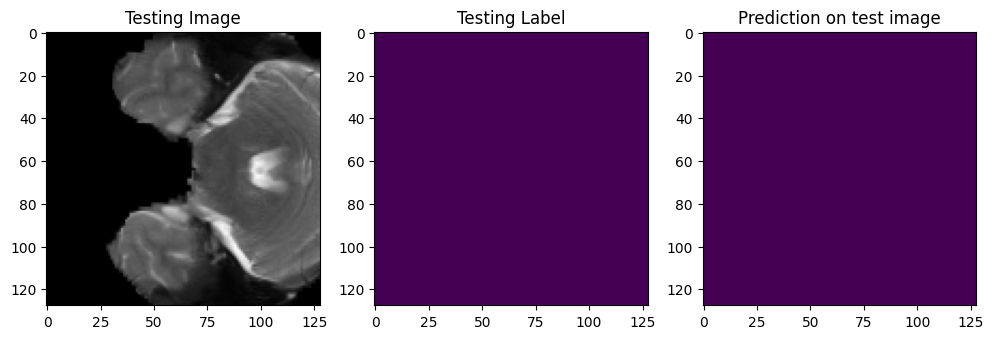

In [222]:
#Plot individual slices from test predictions for verification
n_slice=random.randint(0, prediction_argmax.shape[2])
# n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_argmax[:,:, n_slice])
plt.show()